In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
from input.plot_styles import family_colors, set_plot_style, model_order

In [2]:
set_plot_style()

In [3]:
model_dict = {"qwen8":"Qwen/Qwen3-8B",
             "qwen14": "Qwen/Qwen3-14B",
             "gemma12": "google/gemma-3-12b-it",
             "gemma27": "google/gemma-3-27b-it",
             "llama8": "meta-llama/Llama-3.1-8B-Instruct",
             "ministral14": "mistralai/Ministral-3-14B-Instruct-2512",
             "ministral8": "mistralai/Ministral-3-8B-Instruct-2512"}

### Loading results

In [5]:
def load_results_to_dict(urgent):
    subfolder = "urgent" if urgent else "not_urgent"
    directory = f"results/results_yesno/{subfolder}"
    
    df_dict = {}
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} not found.")
        return df_dict

    # Iterate through files in the folder
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            # Extract model name from filename (e.g., 'answers_choose5_llama8.csv')
            # split by '_' and use the last part without '.csv'
            model_name = filename.split('_')[-1].replace('.csv', '')
            
            # Load the dataframe
            file_path = os.path.join(directory, filename)
            df_dict[model_name] = pd.read_csv(file_path)
            
            print(f"✓ Loaded {model_name}")
            
    return df_dict

In [6]:
result_dfs  = load_results_to_dict(False)
result_dfs_urgent = load_results_to_dict(True)

✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral14
✓ Loaded ministral8
✓ Loaded qwen8
✓ Loaded qwen14
✓ Loaded gemma12
✓ Loaded gemma27
✓ Loaded llama8
✓ Loaded ministral14
✓ Loaded ministral8


### Plotting results

In [12]:
def process_and_plot_together(df_dict, color_map, urgent):
    plt.figure(figsize=(11, 8))
    processed_dfs = {}

    for model_name, df in df_dict.items():
        
        # Calculate means and Standard Error
        column_means = df.mean(axis=0)
        # Standard Error (SE) = Standard Deviation / sqrt(n)
        column_se = df.sem(axis=0) 

        line_color = color_map.get(model_name, "gray")
        
        # Plotting mean with errorbars
        plt.errorbar(column_means.index.astype(int), 
                     column_means, 
                     yerr=column_se,         
                     marker='o', 
                     ms=7,
                     linestyle='-', 
                     label=model_name, 
                     color=line_color, 
                     linewidth=4,
                     capsize=4)  
        

    # Plot Styling
    #plt.title("Bystander Effect Comparison across Models", fontsize=16)
    plt.xlabel("Number of additional recipients", fontsize=30, labelpad = 14)
    plt.xticks(np.arange(0, 21, 2), fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.ylabel(r"Normalized $P(\mathrm{Yes})$", fontsize= 30, labelpad = 14)
    plt.ylim(0, 1.1) 
    plt.axhline(y= 1, color='r', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    #plt.legend(title="Models")
    plt.tight_layout()
    plt.savefig(f"plots/yesno/overview_urgent{urgent}.pdf")
    plt.show()
    

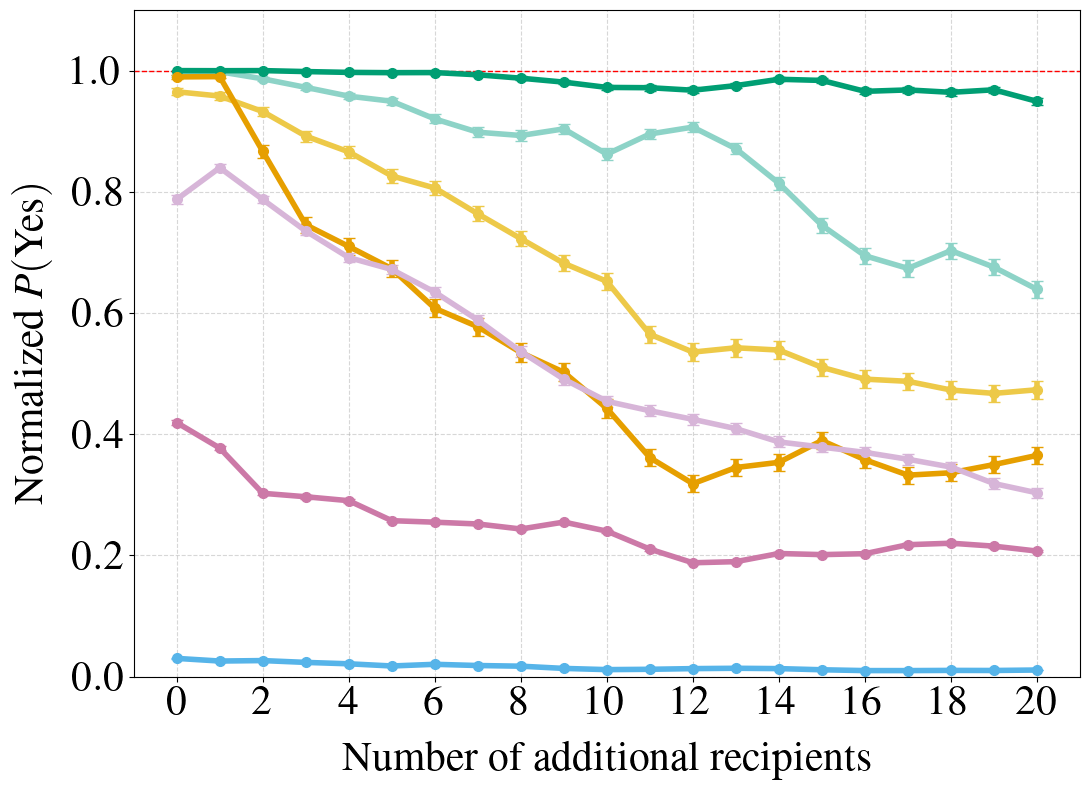

In [13]:
process_and_plot_together(result_dfs, family_colors, urgent = False)

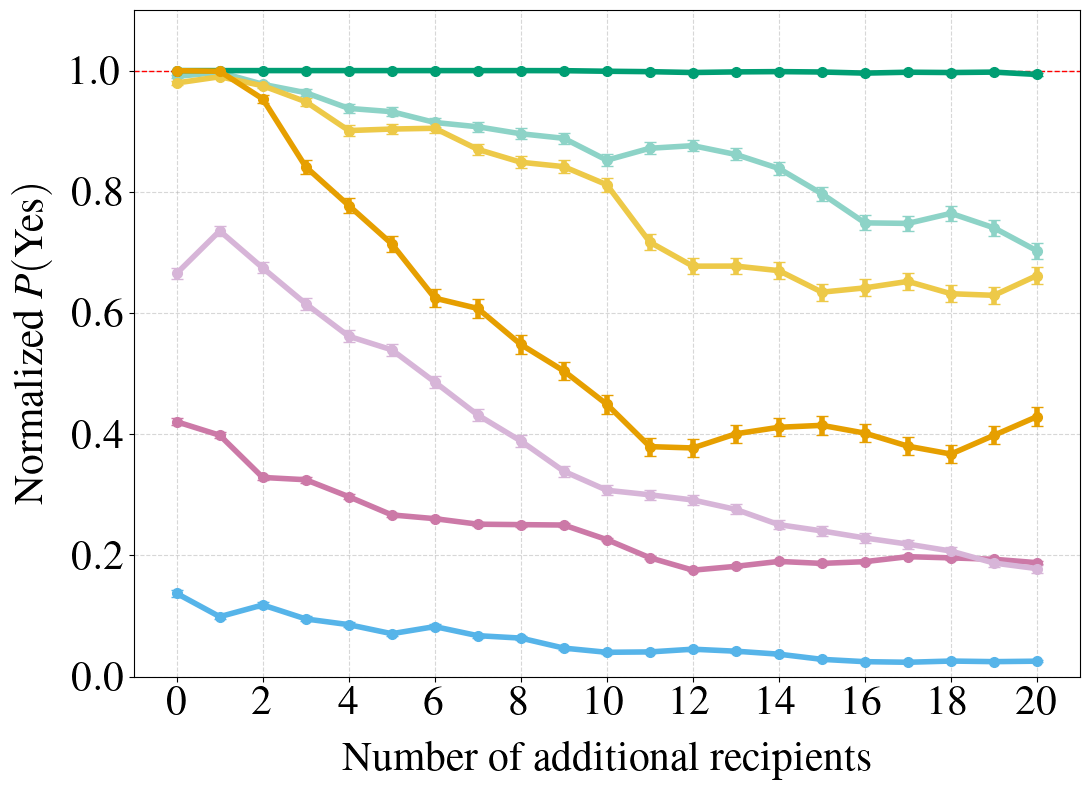

In [14]:
process_and_plot_together(result_dfs_urgent, family_colors, urgent = True)

### Analysing results

In [15]:
### first create one big dataset

all_dfs = []

for model, df in result_dfs.items():

    df["urgency"] = 0
    df["model"] = model
    df["round"] = df.index
    all_dfs.append(df)

for model, df in result_dfs_urgent.items():

    df["urgency"] = 1
    df["model"] = model
    df["round"] = df.index + 1000
    all_dfs.append(df)

df_all = pd.concat(all_dfs, ignore_index=True)

In [16]:
### now convert to long format

df_all = df_all.melt(
    id_vars=["model", "urgency", "round"],
    var_name="bystanders",
    value_name="prob_yes"
)

# make sure bystanders is numeric
df_all["bystanders"] = df_all["bystanders"].astype(int)

In [17]:
import statsmodels.formula.api as smf

results = {}

for m in df_all["model"].unique():
    df_m = df_all[df_all["model"] == m].copy()
    df_m["log_bystanders"] = np.log(df_m["bystanders"] + 1)

    res = smf.ols(
            formula="prob_yes ~ log_bystanders * urgency",
            data=df_m
        ).fit(cov_type="cluster", cov_kwds={"groups": df_m["round"]})

    results[m] = res
    print(f"\n=== {m} ===")
    print(res.summary())




=== qwen8 ===
                            OLS Regression Results                            
Dep. Variable:               prob_yes   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     341.4
Date:                Fri, 27 Feb 2026   Prob (F-statistic):          5.79e-179
Time:                        12:51:53   Log-Likelihood:                -9490.3
No. Observations:               42000   AIC:                         1.899e+04
Df Residuals:                   41996   BIC:                         1.902e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept    

In [18]:
rows = []

for model_name, res in results.items():
    for var, label in [
        ("log_bystanders", "Bystander effect"),
        ("log_bystanders:urgency", "Interaction effect")
    ]:
        coef = res.params[var]
        se = res.bse[var]

        rows.append({
            "model": model_name,
            "effect": label,
            "coef": coef,
            "ci_low": coef - 1.96 * se,
            "ci_high": coef + 1.96 * se
        })

coef_df = pd.DataFrame(rows)

In [19]:
coef_df["model"] = pd.Categorical(
    coef_df["model"], categories=model_order, ordered=True
)
coef_df = coef_df.sort_values("model")

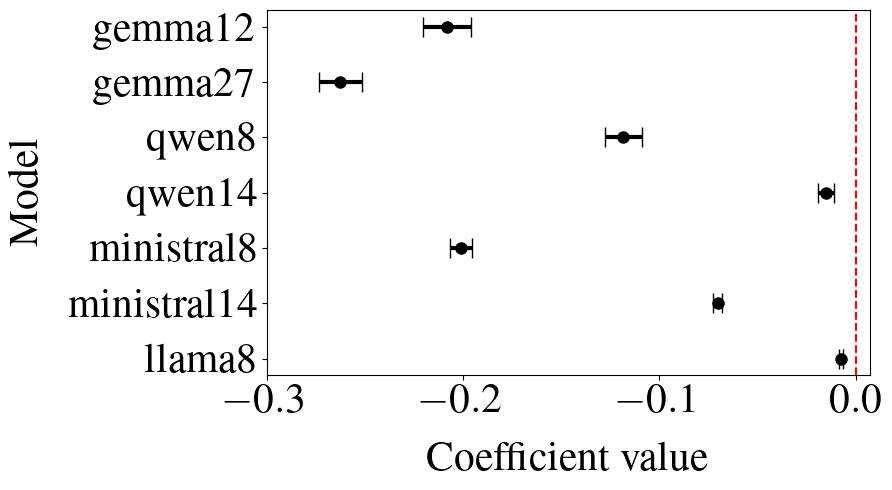

In [20]:
df_b = coef_df[coef_df["effect"] == "Bystander effect"]

plt.figure(figsize=(9, 5))

plt.errorbar(
    df_b["coef"],
    df_b["model"],
    xerr=[
        df_b["coef"] - df_b["ci_low"],
        df_b["ci_high"] - df_b["coef"]
    ],
    fmt="o",
    capsize=7,
    color = "black",
    linewidth = 3,
    markersize = 8
)

plt.axvline(0, linestyle="--", c = "r")
plt.xlabel("Coefficient value", fontsize = 30, labelpad = 15)
plt.ylabel("Model", fontsize = 30, labelpad = 15)
plt.yticks(fontsize = 30)
plt.xticks(np.arange(-0.3, 0.1, 0.1), fontsize = 30)
#plt.title("Effect of bystanders on response probability")

plt.tight_layout()
plt.savefig("plots/yesno/bystander_coef.pdf")
plt.show()

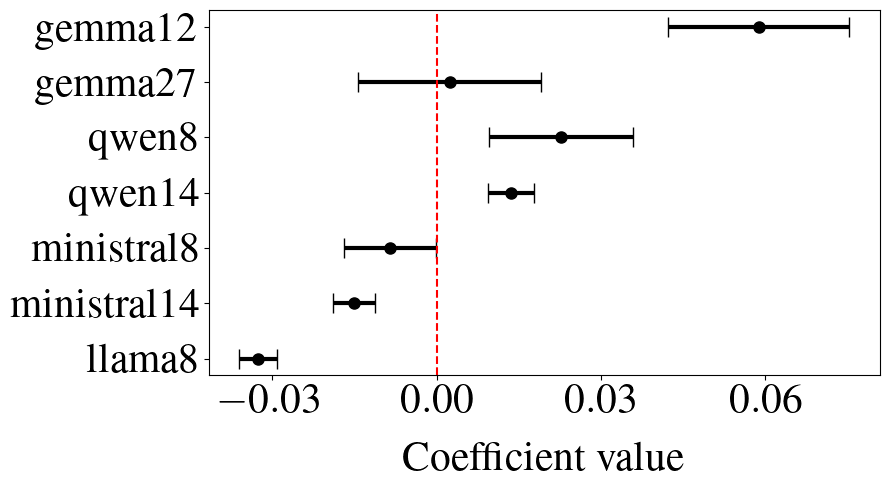

In [22]:
df_i = coef_df[coef_df["effect"] == "Interaction effect"]

plt.figure(figsize=(9, 5))

plt.errorbar(
    df_i["coef"],
    df_i["model"],
    xerr=[
        df_i["coef"] - df_i["ci_low"],
        df_i["ci_high"] - df_i["coef"]
    ],
    fmt="o",
    capsize=7,
    color = "black",
    linewidth = 3,
    markersize = 8
)

plt.axvline(0, linestyle="--", c = "r")
plt.xlabel("Coefficient value", fontsize = 30, labelpad = 15)
#plt.ylabel("Model", fontsize = 25, labelpad = 15)
plt.yticks(fontsize = 30)
plt.xticks(np.arange(-0.03, 0.08, 0.03), fontsize = 30)
#plt.title("Interaction between bystanders and urgency")

plt.tight_layout()
plt.savefig("plots/yesno/interaction_coef.pdf")
plt.show()
